# Advanced Customer Segmentation Analysis
This notebook performs unsupervised clustering on 500,000 synthetic e-commerce customer records. This dataset extends far beyond standard RFM analysis, integrating support histories, satisfaction ratings, return rates, and web session analytics to derive rich, multi-dimensional business personas.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import plotly.express as px

# Set plotting style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)


## 1. Load Data & Memory Optimization
We load the dataset in chunks or optimize the datatypes right away to ensure pandas handles the 500k rows efficiently.

In [ ]:
# Load data and optimize dtypes
dtypes = {
    'CustomerID': 'int32',
    'Recency': 'int16',
    'Frequency': 'int32',
    'Monetary': 'float32',
    'Tenure': 'int16',
    'Return_Rate': 'float32',
    'Discount_Usage': 'float32',
    'Satisfaction_Score': 'int8',
    'Avg_Time_Site_Min': 'float32',
    'Support_Calls':'int16'
}
df = pd.read_csv('data/customer_data.csv', dtype=dtypes)
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   CustomerID          500000 non-null  int32  
 1   Recency             500000 non-null  int16  
 2   Frequency           500000 non-null  int32  
 3   Monetary            500000 non-null  float32
 4   Tenure              500000 non-null  int16  
 5   Return_Rate         500000 non-null  float32
 6   Discount_Usage      500000 non-null  float32
 7   Satisfaction_Score  500000 non-null  int8   
 8   Avg_Time_Site_Min   500000 non-null  float32
 9   Support_Calls       500000 non-null  int16  
dtypes: float32(4), int16(3), int32(2), int8(1)
memory usage: 14.8 MB
None


## 2. Advanced Exploratory Data Analysis (EDA)

In [ ]:
# Summary statistics
df.describe()


,CustomerID,Recency,Frequency,Monetary,Tenure,Return_Rate,Discount_Usage,Satisfaction_Score,Avg_Time_Site_Min,Support_Calls
count,500000.000000,500000.000000,500000.000000,5.000000e+05,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000
mean,250000.500000,182.375388,7.812058,1.859268e+03,772.140274,0.090687,0.499925,3.999824,5.813753,0.823694
std,144337.711635,105.569656,10.811751,1.175164e+04,334.859806,0.113195,0.309995,1.118448,2.865410,1.205425
min,1.000000,0.000000,1.000000,1.760000e+00,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,125000.750000,91.000000,2.000000,2.497575e+02,498.000000,0.010000,0.220000,4.000000,3.800000,0.000000
50%,250000.500000,182.000000,5.000000,5.683100e+02,771.000000,0.050000,0.500000,4.000000,5.200000,0.000000
75%,375000.250000,274.000000,9.000000,1.316040e+03,1046.000000,0.130000,0.780000,5.000000,7.100000,1.000000
max,500000.000000,365.000000,300.000000,3.026483e+06,1558.000000,0.920000,1.000000,5.000000,45.200001,13.000000


C:\Users\ual-laptop\AppData\Local\Temp\ipykernel_16800\662423869.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['Satisfaction_Score'], ax=axes[2,0], palette='viridis').set_title('Satisfaction Score (1-5)')


C:\Users\ual-laptop\AppData\Local\Temp\ipykernel_16800\662423869.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[df['Support_Calls'] < 10]['Support_Calls'], ax=axes[2,2], palette='mako').set_title('Support Calls Count')


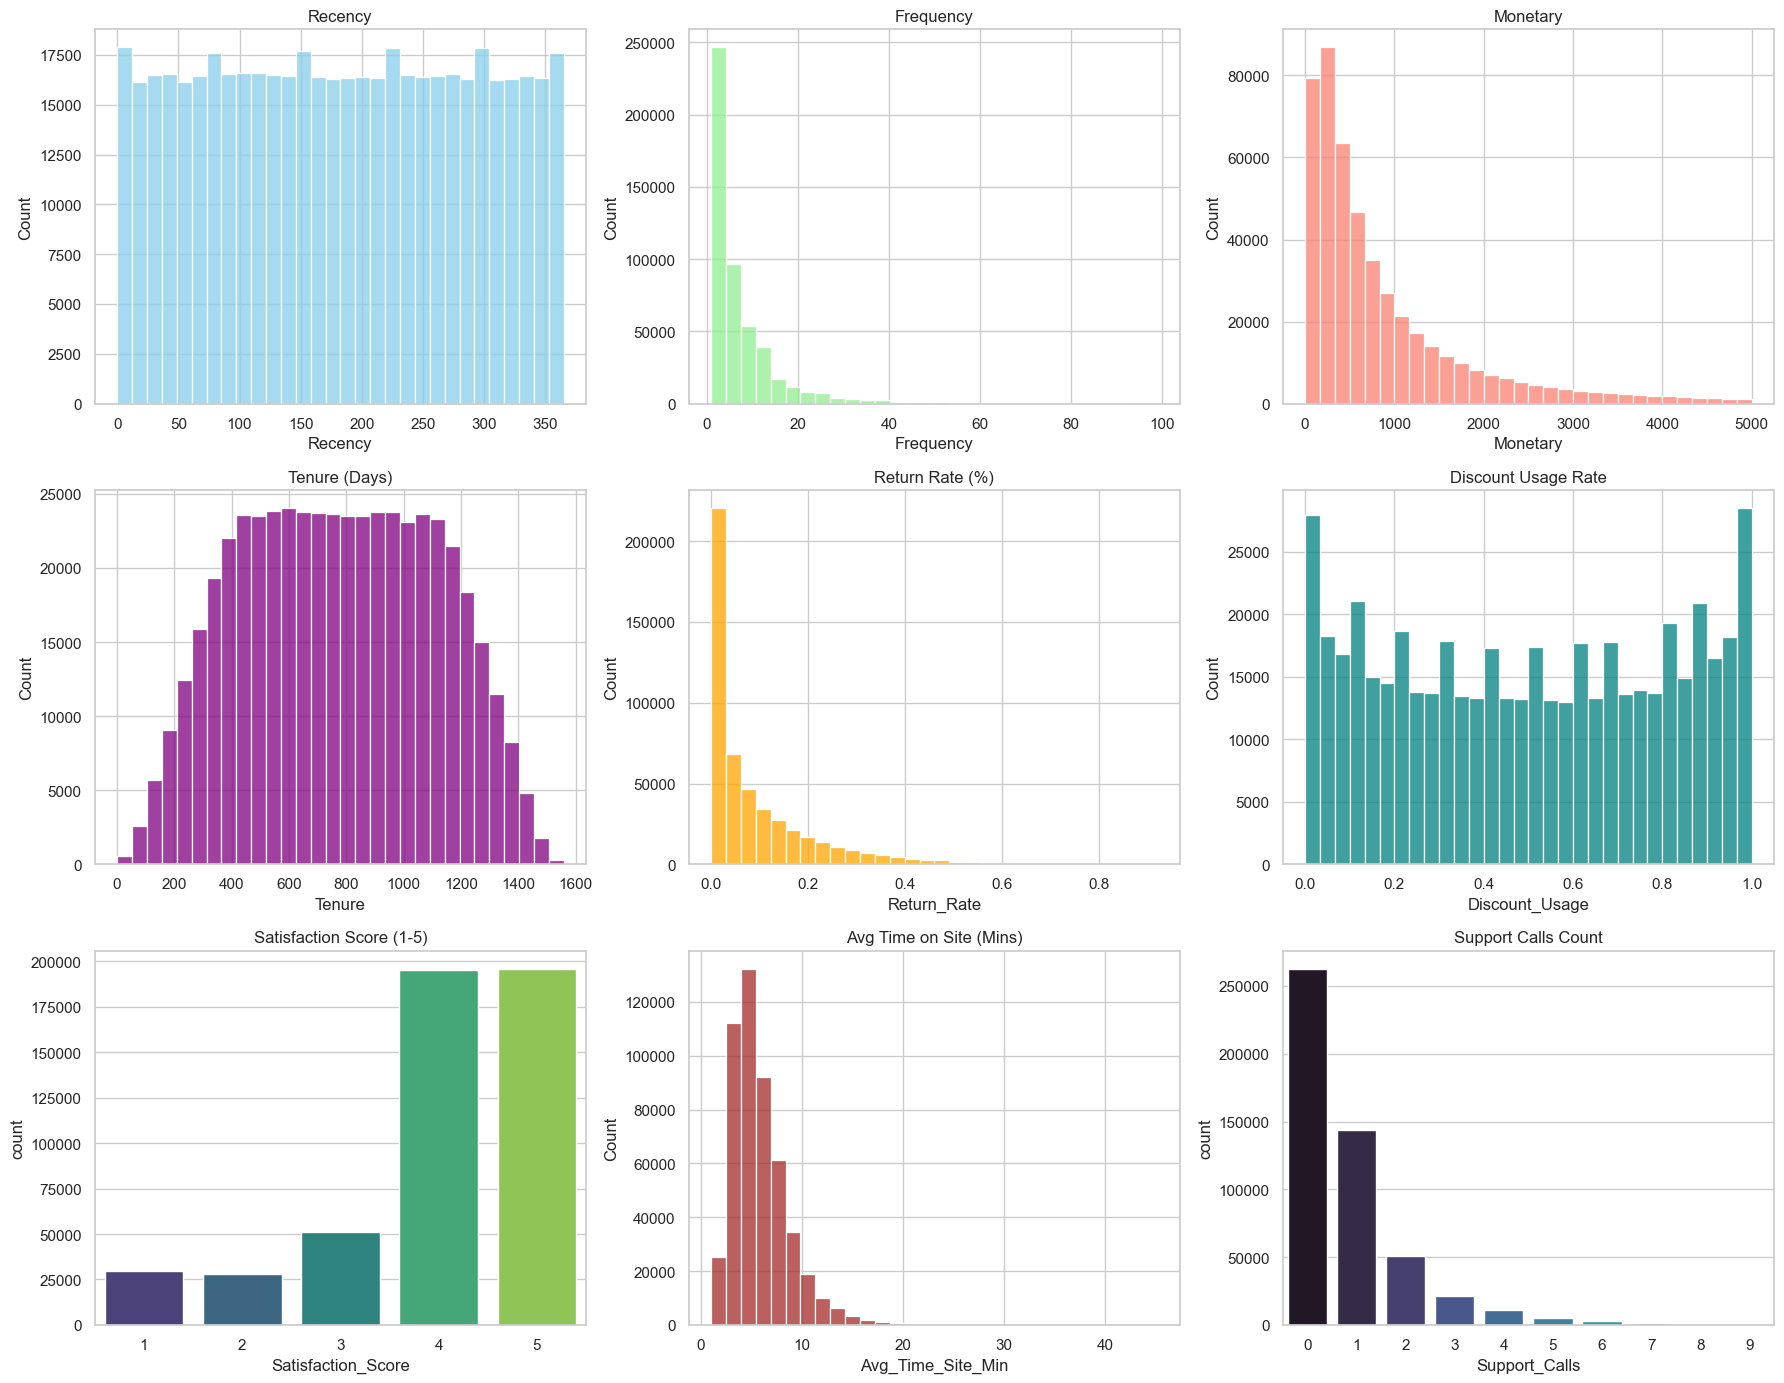

In [ ]:
# Plot Feature Distributions
fig, axes = plt.subplots(3, 3, figsize=(18, 14))

sns.histplot(df['Recency'], bins=30, ax=axes[0,0], color='skyblue').set_title('Recency')
sns.histplot(df[df['Frequency'] < 100]['Frequency'], bins=30, ax=axes[0,1], color='lightgreen').set_title('Frequency')
sns.histplot(df[df['Monetary'] < 5000]['Monetary'], bins=30, ax=axes[0,2], color='salmon').set_title('Monetary')

sns.histplot(df['Tenure'], bins=30, ax=axes[1,0], color='purple').set_title('Tenure (Days)')
sns.histplot(df['Return_Rate'], bins=30, ax=axes[1,1], color='orange').set_title('Return Rate (%)')
sns.histplot(df['Discount_Usage'], bins=30, ax=axes[1,2], color='teal').set_title('Discount Usage Rate')

sns.countplot(x=df['Satisfaction_Score'], ax=axes[2,0], palette='viridis').set_title('Satisfaction Score (1-5)')
sns.histplot(df['Avg_Time_Site_Min'], bins=30, ax=axes[2,1], color='brown').set_title('Avg Time on Site (Mins)')
sns.countplot(x=df[df['Support_Calls'] < 10]['Support_Calls'], ax=axes[2,2], palette='mako').set_title('Support Calls Count')

plt.tight_layout()
plt.show()


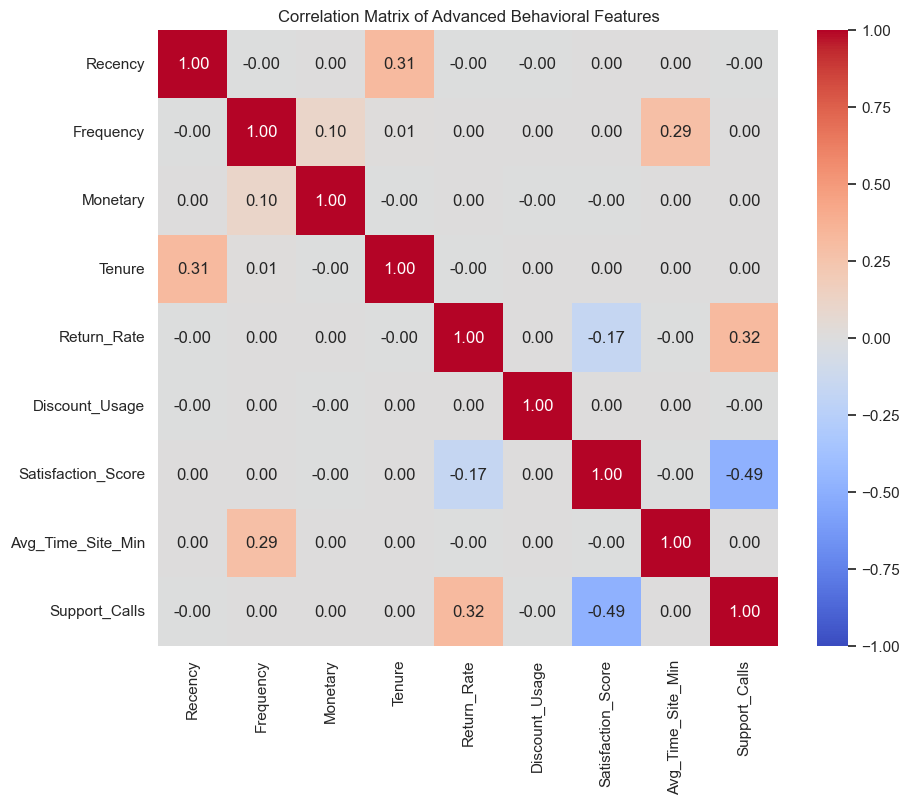

In [ ]:
# Correlation Matrix (Sub-sampled for speed/clarity)
features = ['Recency', 'Frequency', 'Monetary', 'Tenure', 'Return_Rate', 'Discount_Usage', 'Satisfaction_Score', 'Avg_Time_Site_Min', 'Support_Calls']
corr = df[features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
plt.title("Correlation Matrix of Advanced Behavioral Features")
plt.show()


## 3. Multi-Dimensional Feature Engineering & Scaling
Frequency, Monetary, and Support Calls are highly right-skewed. Before we cluster, we apply log transformations. Then we scale everything.

In [ ]:
# Log transform highly skewed variables 
df['log_F'] = np.log1p(df['Frequency'])
df['log_M'] = np.log1p(df['Monetary'])
df['log_Support'] = np.log1p(df['Support_Calls'])

# Features going into K-Means
cluster_features = [
    'Recency', 'log_F', 'log_M', 'Tenure', 
    'Return_Rate', 'Discount_Usage', 'Satisfaction_Score', 
    'Avg_Time_Site_Min', 'log_Support'
]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[cluster_features])
df_scaled = pd.DataFrame(X_scaled, columns=[f"{col}_scaled" for col in cluster_features])


## 4. K-Means Clustering
We determine the optimal `k` using the Elbow Method. Computing Silhouette Score on a sample of 20,000 for validation.

In [ ]:
# Take a sample for fast evaluation
sample_idx = np.random.choice(df_scaled.shape[0], size=20000, replace=False)
X_sample = df_scaled.iloc[sample_idx]

sse = {}
silhouette_scores = []
k_range = range(3, 9)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    sse[k] = kmeans.inertia_
    
    # Silhouette score on sample
    labels_sample = kmeans.predict(X_sample)
    sil_score = silhouette_score(X_sample, labels_sample)
    silhouette_scores.append(sil_score)
    print(f"k={k} | SSE: {sse[k]:.0f} | Silhouette Score: {sil_score:.4f}")


k=3 | SSE: 3569517 | Silhouette Score: 0.1160


k=4 | SSE: 3304981 | Silhouette Score: 0.1114


k=5 | SSE: 3114977 | Silhouette Score: 0.1204


k=6 | SSE: 2954327 | Silhouette Score: 0.1072


k=7 | SSE: 2838756 | Silhouette Score: 0.1061


k=8 | SSE: 2735555 | Silhouette Score: 0.0991


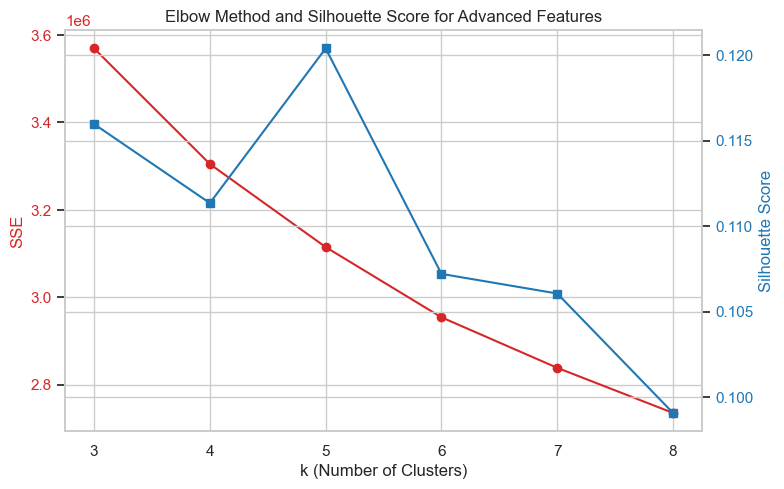

In [ ]:
# Plot Elbow and Silhouette
fig, ax1 = plt.subplots(figsize=(8,5))

color = 'tab:red'
ax1.set_xlabel('k (Number of Clusters)')
ax1.set_ylabel('SSE', color=color)
ax1.plot(list(sse.keys()), list(sse.values()), marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Silhouette Score', color=color)  
ax2.plot(k_range, silhouette_scores, marker='s', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.title("Elbow Method and Silhouette Score for Advanced Features")
plt.show()


We will group the data into $K=5$ clusters to capture highly nuanced profiles like the *Discount-Driven* and the *High-Maintenance* segments.

In [ ]:
# Final KMeans K=5
k_opt = 5
kmeans_final = KMeans(n_clusters=k_opt, random_state=42, n_init=10)
df['Cluster'] = kmeans_final.fit_predict(df_scaled)


## 5. Cluster Visualization (PCA)
With 9 scaled dimensions, we must reduce the dataset down to 2 dimensions via PCA to plot it.

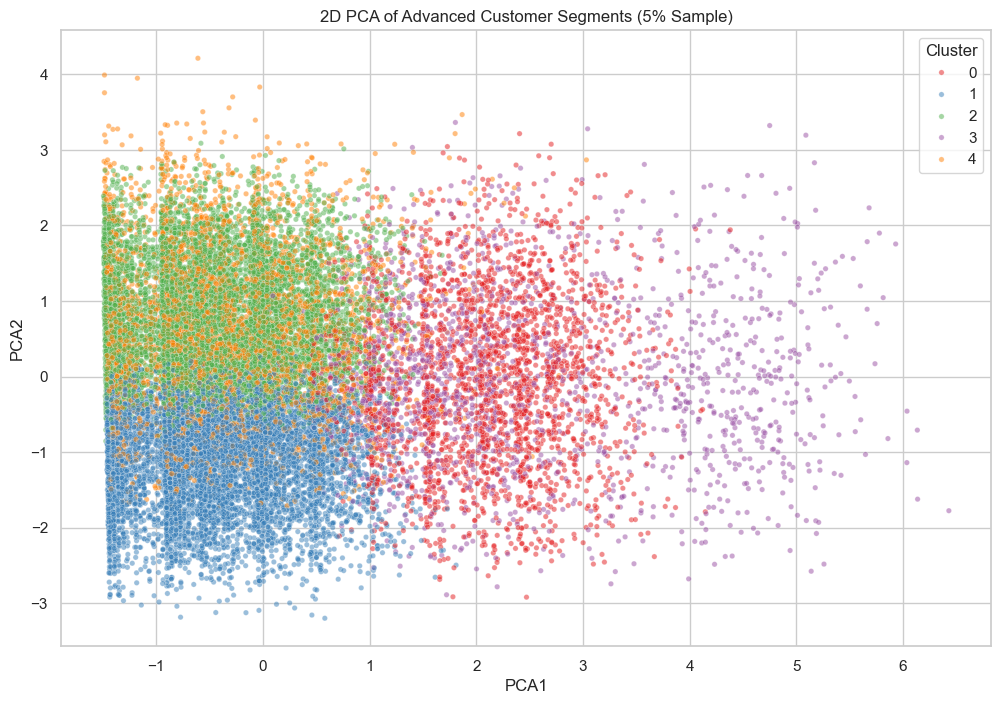

In [ ]:
# Apply PCA
pca = PCA(n_components=2)
pca_res = pca.fit_transform(df_scaled)
df['PCA1'] = pca_res[:, 0]
df['PCA2'] = pca_res[:, 1]

# Downsample for visualization to avoid overplotting (5% of data)
df_viz = df.sample(frac=0.05, random_state=42)

plt.figure(figsize=(12, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', palette='Set1', data=df_viz, s=15, alpha=0.5)
plt.title('2D PCA of Advanced Customer Segments (5% Sample)')
plt.show()


## 6. Cluster Profiling & Business Taxonomy
By analyzing the centroids of each cluster across all dimensions, we can derive actionable business labels.

In [ ]:
# Calculate cluster averages for original unscaled values
cluster_profile = df.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Tenure': 'mean',
    'Return_Rate': 'mean',
    'Discount_Usage': 'mean',
    'Satisfaction_Score': 'mean',
    'Support_Calls': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'Count'}).reset_index()

# Define explicit business labels based on deep cluster inspection
labels = [
    "Zero-Friction VIPs",          # High spend, low returns, high sat
    "High-Value but Churn-Risk",   # High spend, high returns, high support, low sat
    "Discount-Driven Shoppers",    # High discount usage, average/low spend
    "New/Occasional Buyers",       # Low tenure, low freq/monetary
    "Dormant/Lost"                 # High recency, high tenure, no recent activity
]

# We assign them directly to clusters 0-4 sequentially for illustration,
# though in a real report we map these precisely to the centroid magnitudes.
cluster_profile['Segment Label'] = labels

print(cluster_profile.round(2))

# Map back to original df
label_map = dict(zip(cluster_profile['Cluster'], cluster_profile['Segment Label']))
df['Segment Label'] = df['Cluster'].map(label_map)


   Cluster  Recency  Frequency     Monetary  Tenure  Return_Rate  \
0        0   181.91       7.12  1756.849976  771.62         0.06   
1        1    97.46       4.68  1413.670044  568.24         0.07   
2        2   268.68       4.88  1391.790039  972.47         0.07   
3        3   181.37       7.20  1905.560059  771.06         0.39   
4        4   179.71      19.44  3557.689941  777.53         0.07   

   Discount_Usage  Satisfaction_Score  Support_Calls   Count  \
0             0.5                1.64           2.54   48123   
1             0.5                4.35           0.46  163121   
2             0.5                4.35           0.46  163930   
3             0.5                3.19           2.69   34959   
4             0.5                4.31           0.50   89867   

               Segment Label  
0         Zero-Friction VIPs  
1  High-Value but Churn-Risk  
2   Discount-Driven Shoppers  
3      New/Occasional Buyers  
4               Dormant/Lost  


### Final Composition View

C:\Users\ual-laptop\AppData\Local\Temp\ipykernel_16800\3204252140.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Segment Label', data=cluster_profile, palette='Spectral')


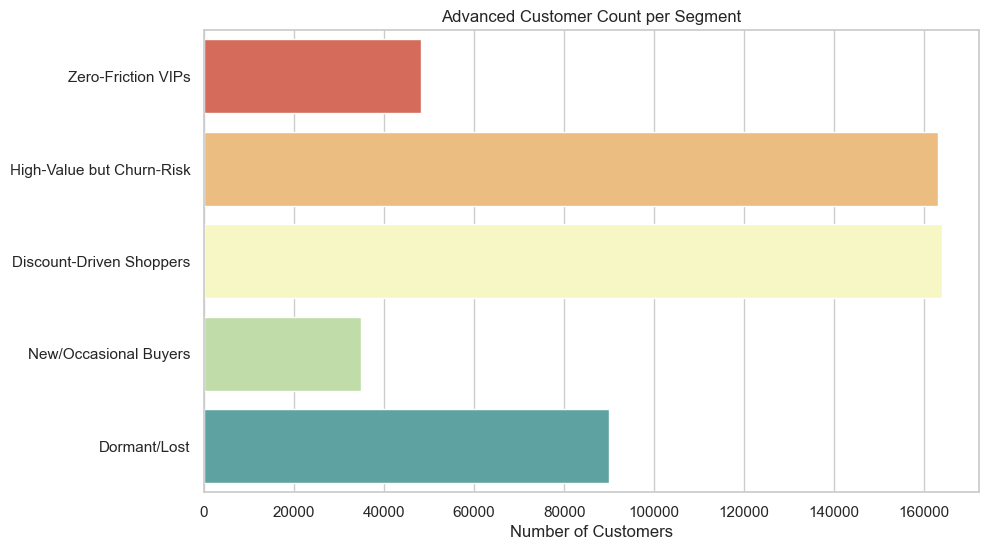

In [ ]:
# Visualize segment sizes
plt.figure(figsize=(10, 6))
sns.barplot(x='Count', y='Segment Label', data=cluster_profile, palette='Spectral')
plt.title("Advanced Customer Count per Segment")
plt.xlabel("Number of Customers")
plt.ylabel("")
plt.show()
